In [61]:
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

from lapjax import ADLaplace
import matplotlib.pyplot as plt
import seaborn as sns
import optax
from tqdm import trange

 20%|██        | 20/100 [00:03<00:14,  5.64it/s]/tmp/ipykernel_947261/1290111143.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


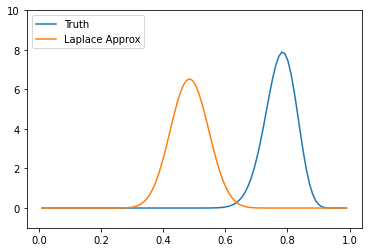

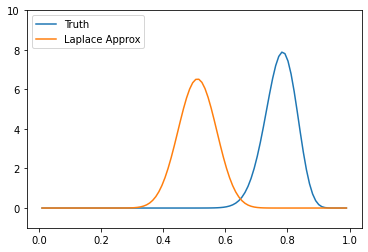

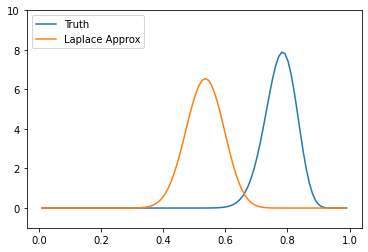

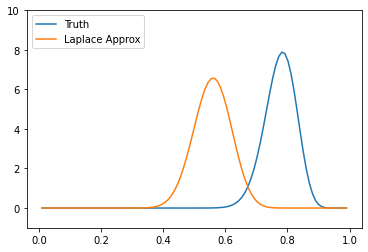

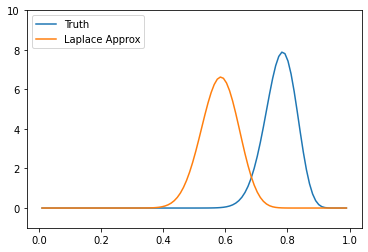

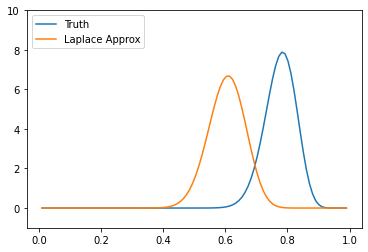

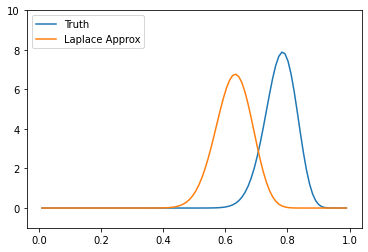

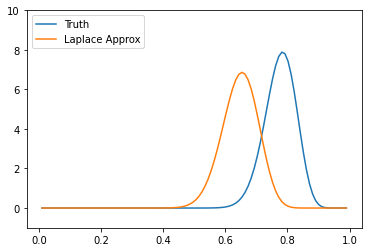

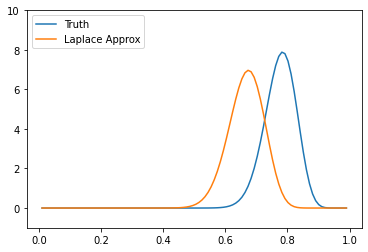

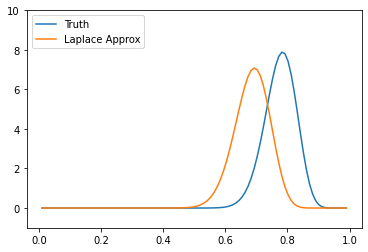

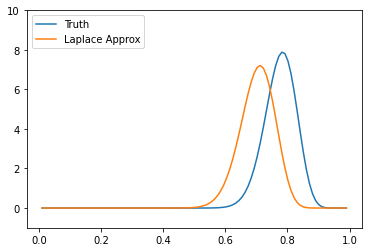

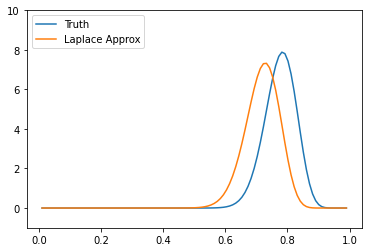

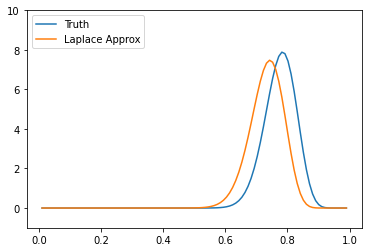

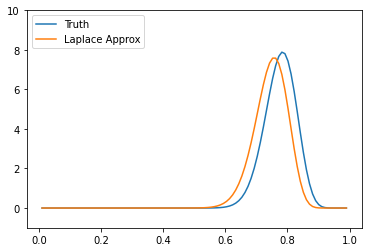

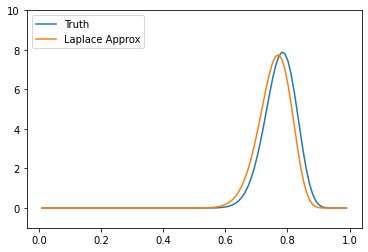

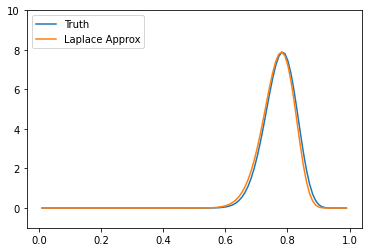

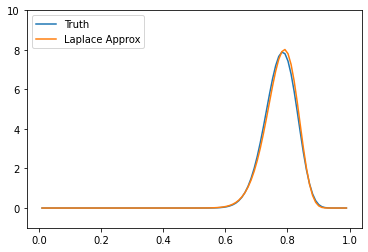

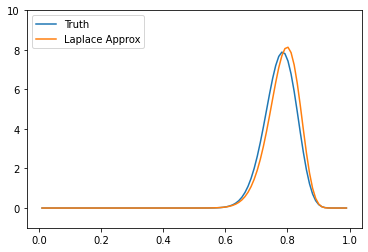

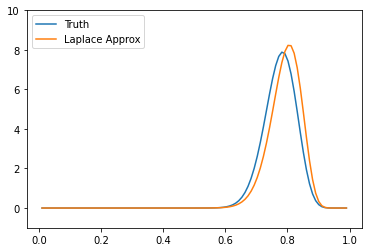

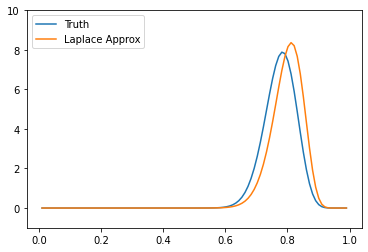

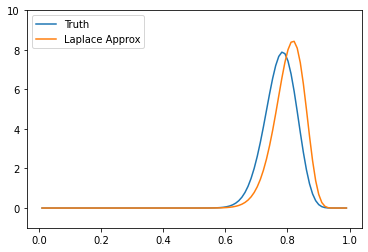

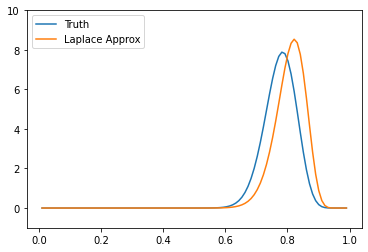

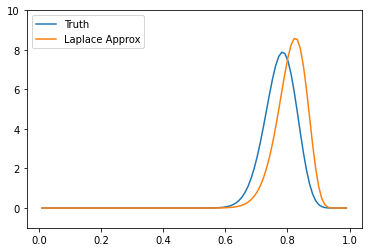

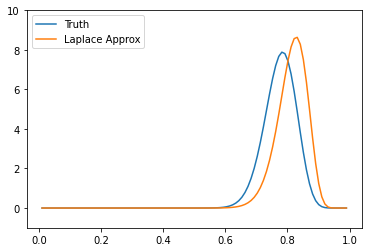

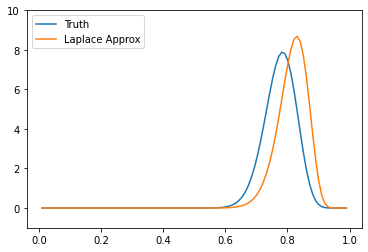

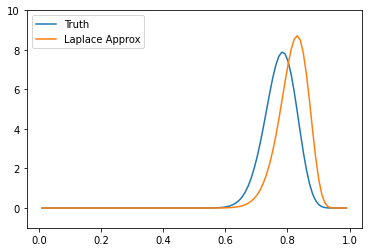

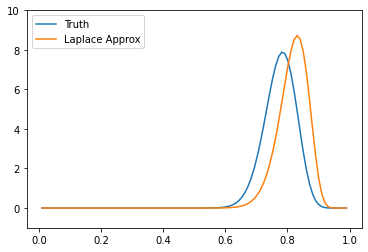

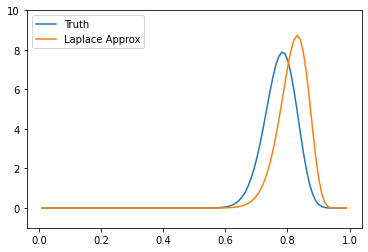

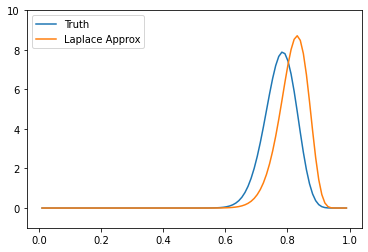

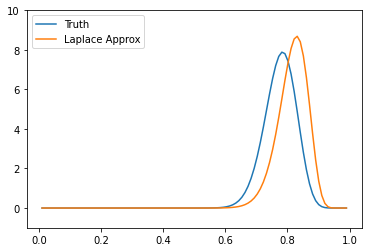

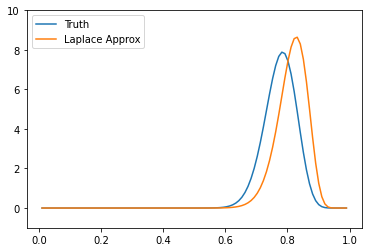

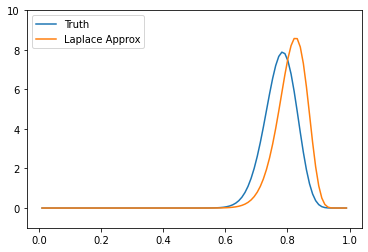

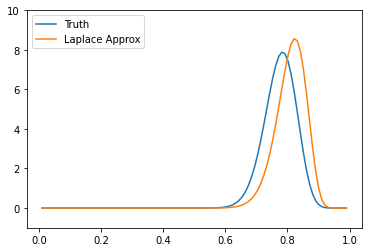

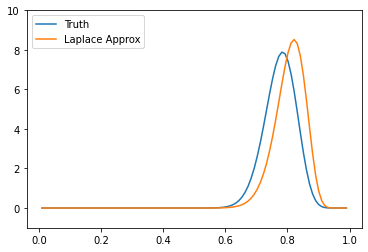

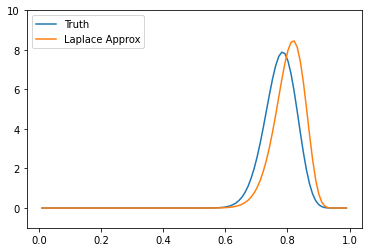

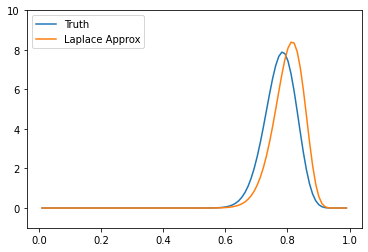

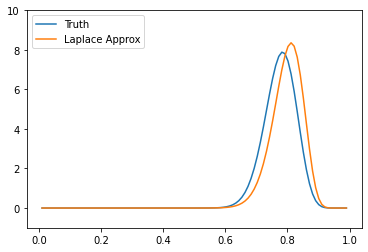

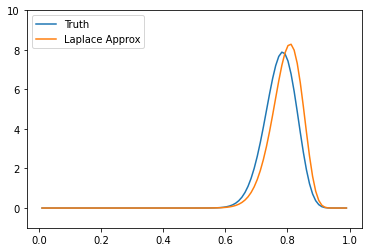

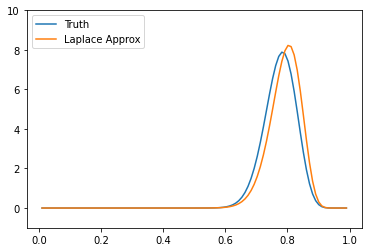

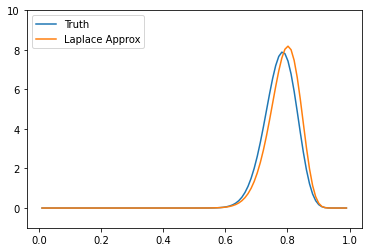

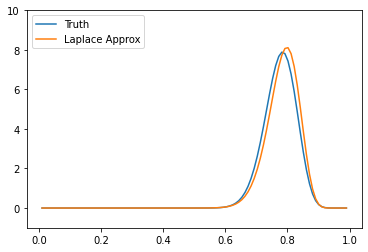

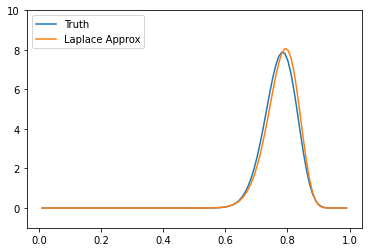

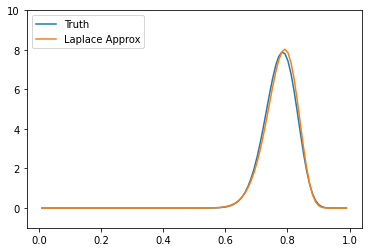

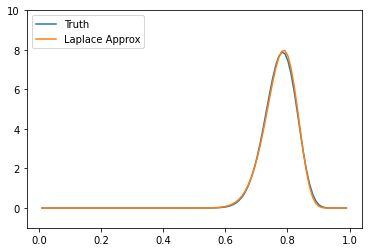

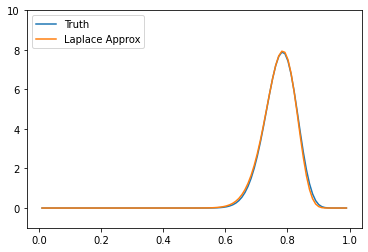

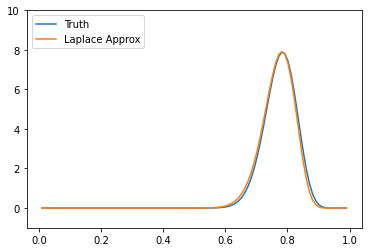

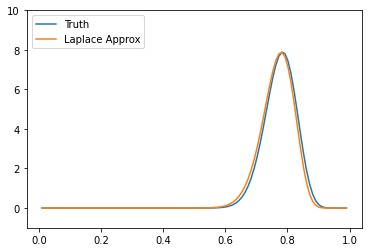

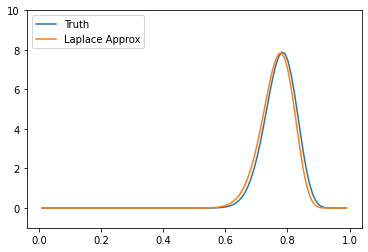

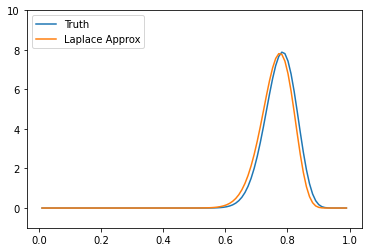

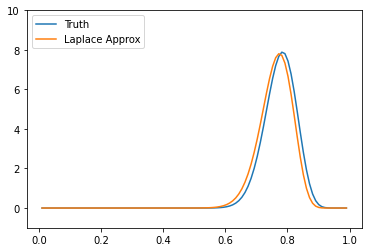

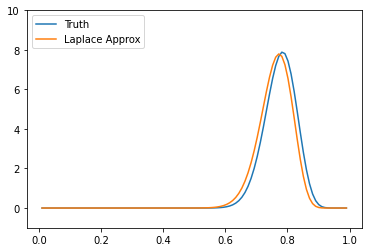

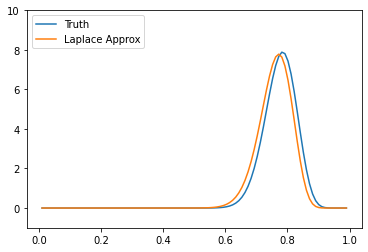

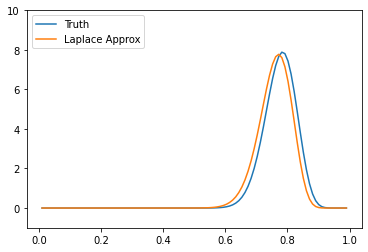

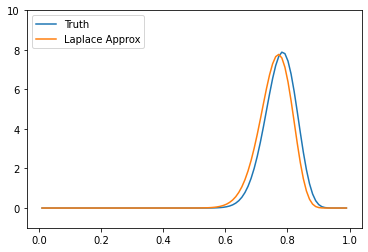

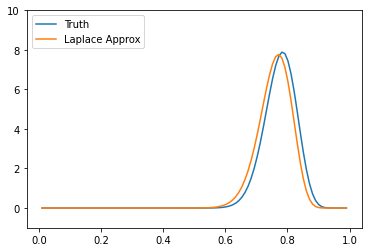

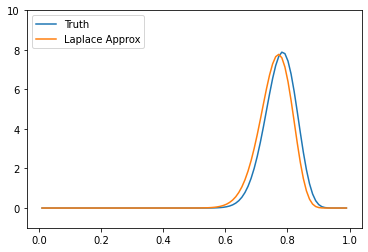

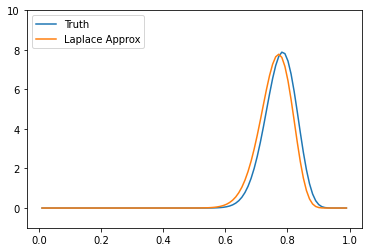

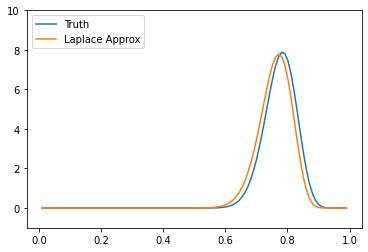

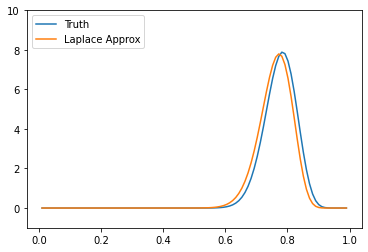

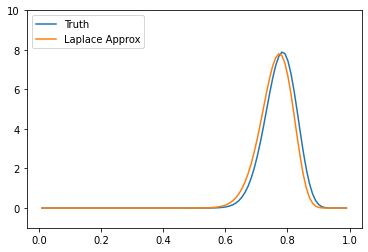

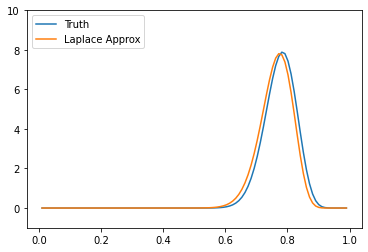

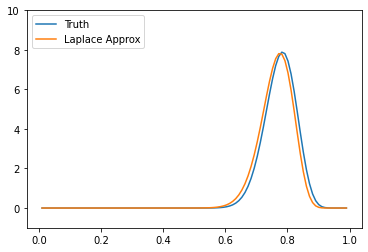

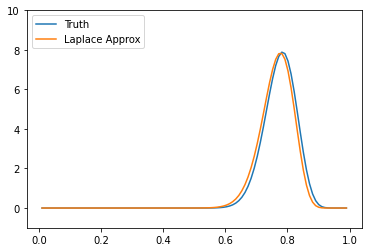

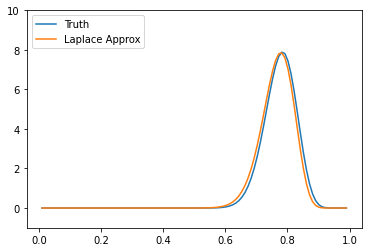

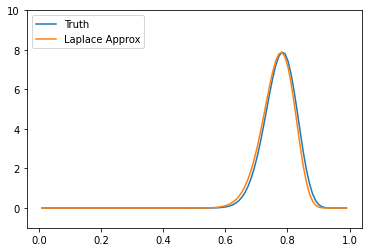

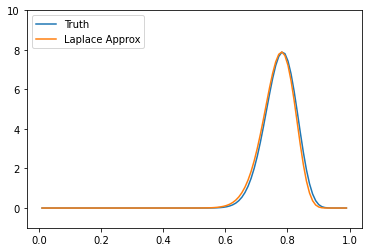

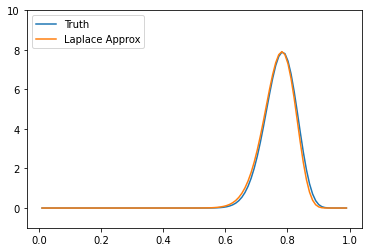

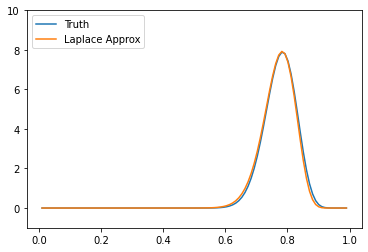

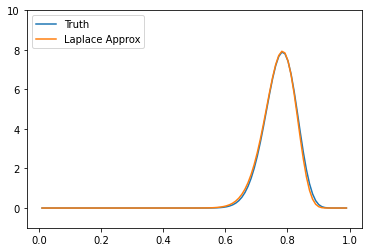

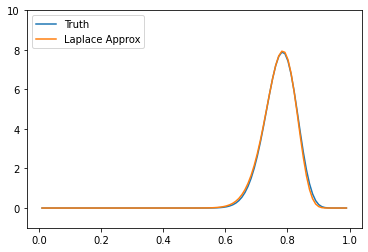

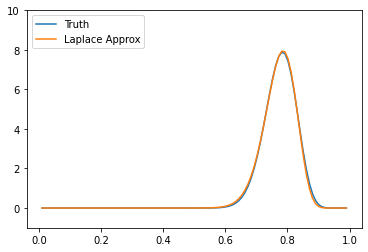

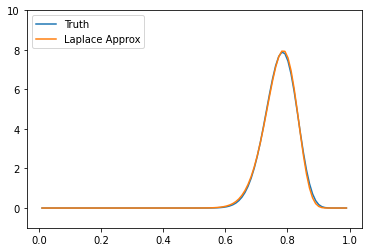

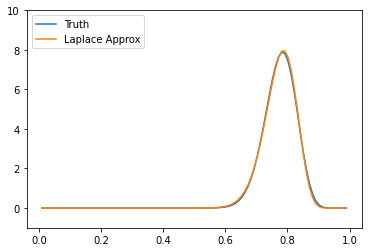

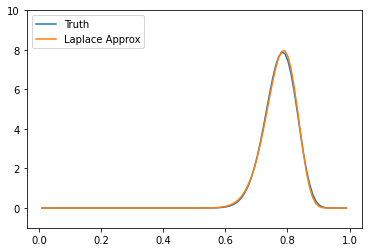

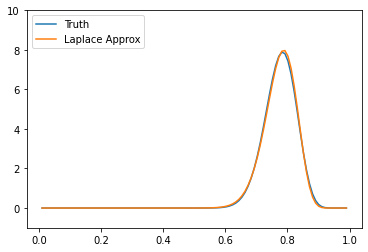

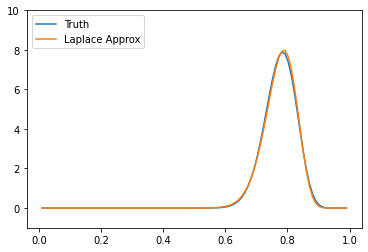

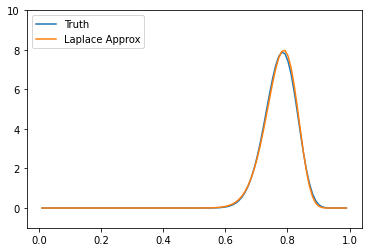

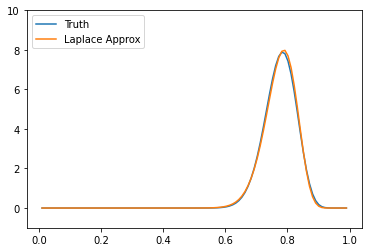

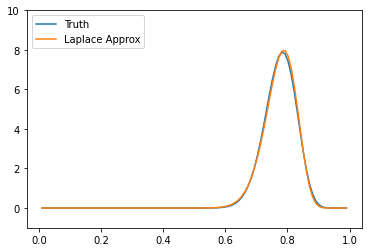

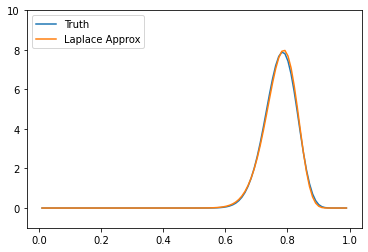

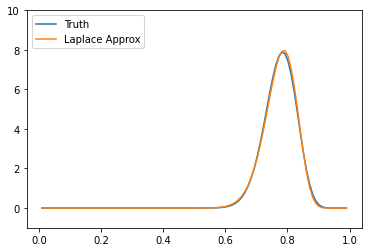

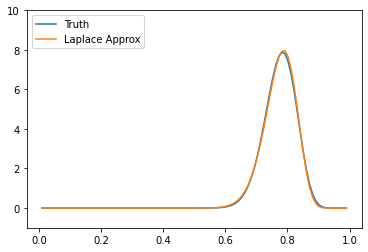

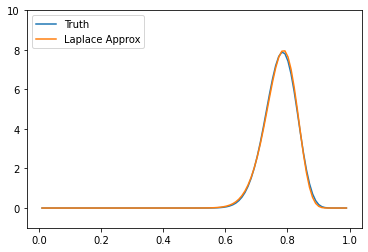

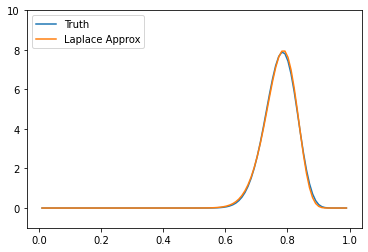

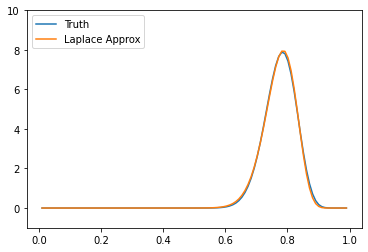

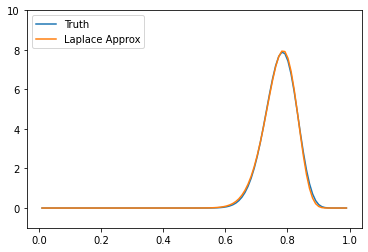

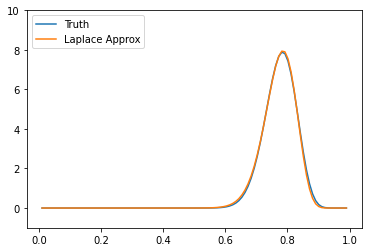

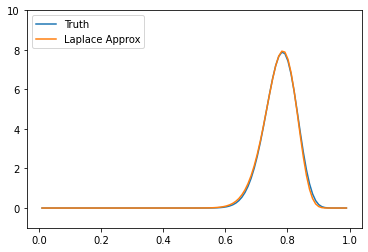

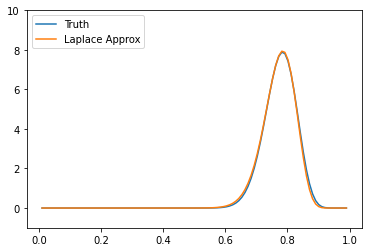

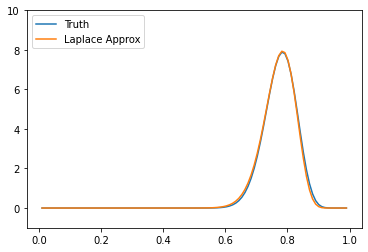

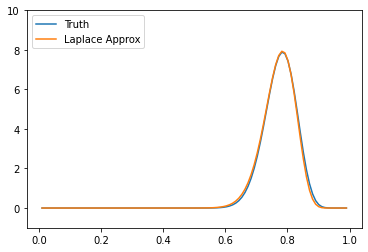

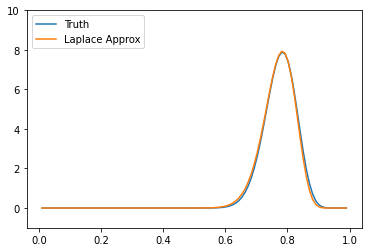

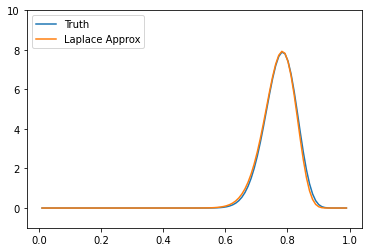

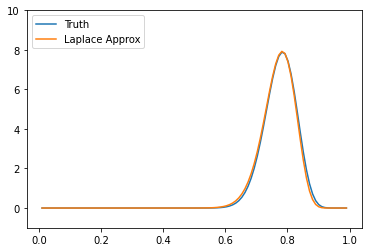

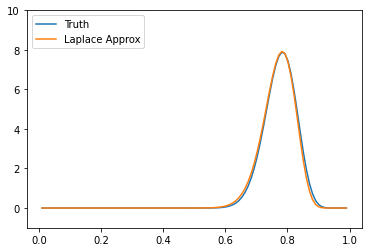

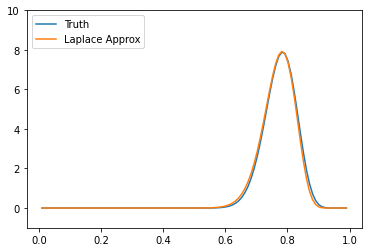

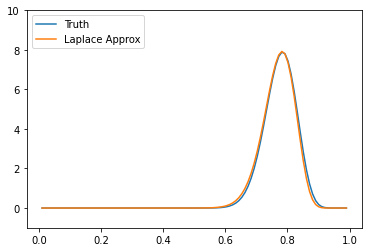

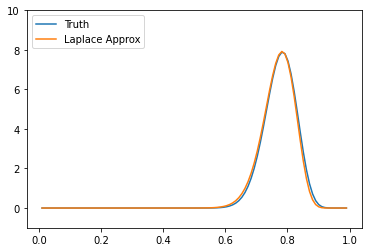

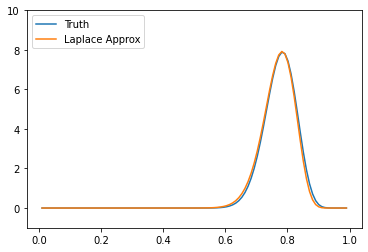

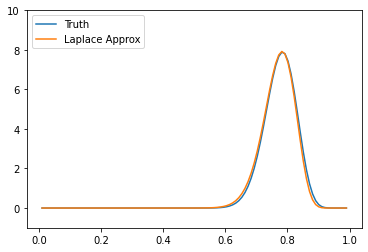

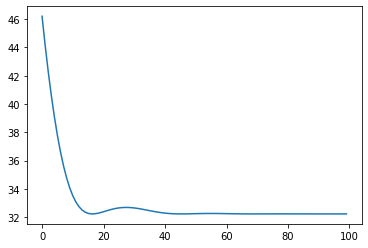

In [70]:
h0 = 2.0
t0 = 5.0
h = 50
t = 10

prior = {"p_of_heads": tfd.Beta(h0, t0)}
bijectors = {"p_of_heads": tfb.Sigmoid()}
data = jnp.array([1]*h + [0]*t)
likelihood = tfd.Bernoulli
get_likelihood_params = lambda params, aux: {"probs": params["p_of_heads"]}

laplace = ADLaplace(prior, bijectors, likelihood, get_likelihood_params)

init_seed = jax.random.PRNGKey(0)
params = laplace.init(init_seed)

value_and_grad_fun = jax.jit(jax.value_and_grad(laplace.loss_fun))
# value_and_grad_fun = jax.value_and_grad(loss_fun)

tx = optax.adam(learning_rate=0.1)
state = tx.init(params)

epochs = 100
seed = jax.random.PRNGKey(1)
seeds = jax.random.split(seed, num=epochs)

losses = []

for i in trange(epochs):
    loss, grads = value_and_grad_fun(params, data)
    losses.append(loss)
    updates, state = tx.update(grads, state)
    params = optax.apply_updates(params, updates)
    posterior = laplace.apply(params, data)
    sample = posterior.sample(seed=jax.random.PRNGKey(0), sample_shape=(1000, ))
    log_prob = posterior.log_prob(sample)

    real_posterior = tfd.Beta(h0+h, t0+t)

    x = jnp.linspace(0.01, 0.99, 100)
    
    plt.figure()
    plt.plot(x, real_posterior.prob(x), label='Truth');
    plt.plot(x, jnp.exp(jax.vmap(posterior.log_prob)({'p_of_heads': x})), label='Laplace Approx');
    plt.legend(loc='upper left')
    plt.ylim(-1, 10)
    plt.savefig(f'laplax_'+str(i).zfill(2)+'.jpg')

plt.figure()
plt.plot(losses)

In [40]:
from jaxopt import LBFGS, ScipyMinimize, OptaxSolver

In [41]:
import jax.example_libraries.optimizers as opt

In [42]:
init_fun, update_fun, get_params = opt.adam(step_size=0.1)

In [56]:
f = lambda x, y: jnp.square(x + y)
opt = LBFGS(f, has_aux=True)

In [58]:
ans = opt.run(jnp.array(0.1), jnp.array(0.1))

TypeError: expected function with aux output to return a two-element tuple, but got type <class 'jax.interpreters.ad.JVPTracer'> with value Traced<ConcreteArray(0.04000000283122063, dtype=float32, weak_type=True)>with<JVPTrace(level=2/1)> with
  primal = DeviceArray(0.04, dtype=float32, weak_type=True)
  tangent = Traced<ShapedArray(float32[], weak_type=True)>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[], weak_type=True), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f01049ce9d0>, in_tracers=(Traced<ConcreteArray(0.4000000059604645, dtype=float32, weak_type=True):JaxprTrace(level=1/1)>, Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/1)>), out_tracer_refs=[<weakref at 0x7f0104807ae0; to 'JaxprTracer' at 0x7f01048925e0>], out_avals=[ShapedArray(float32[], weak_type=True)], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(square)', 'donated_invars': (False, False), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = mul b a in (c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f01048677f0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))

In [60]:
## Problem definition
prior = {"theta": tfd.MultivariateNormalDiag(loc=[0.0, 1.0], scale_diag=[1.0, 2.0]), "sigma": tfd.Gamma(1, 1)}
bijectors = {"theta": tfb.Identity(), "sigma": tfb.Exp()}
likelihood = tfd.Normal

def get_likelihood_params(params, aux):
    mean = jnp.sum(aux["x"] * params["theta"])
    scale = params["sigma"]
    return {"loc": mean, "scale": scale}

# Data
aux = {"x": jax.random.uniform(jax.random.PRNGKey(0), shape=(100, 2))}
data = jax.random.uniform(jax.random.PRNGKey(1), shape=(100,))

# Laplace object
laplace = ADLaplace(prior, bijectors, likelihood, get_likelihood_params)

# params
params = laplace.init(jax.random.PRNGKey(0))

# loss 
laplace.loss_fun(params, data, aux)

# get posterior
posterior = laplace.apply(params, data, aux)

# get samples and/or log_prob
samples = posterior.sample(seed, sample_shape = (5, 4, 3))
log_probs = posterior.log_prob(samples)

DeviceArray([0.31947473, 0.2890727 , 0.2615638 , 0.12988874], dtype=float32)